<a href="https://colab.research.google.com/github/kburns/cism_dedalus_2023/blob/main/lecture_1_intro_to_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction to Dedalus -- Burgers & KdV Equations

**Overview:** This notebook provides a brief (~30 min) introduction to [Dedalus](http://dedalus-project.org).
It assumes familiarity with linear PDEs and basic numerical methods (e.g. ODE integration) at the undergraduate level.
The tutorial introduces the basic Dedalus v3 API and walks through setting up and solving the 1D Burgers and KdV equations.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using global spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

**Author:** [Keaton Burns](http://keaton-burns.com)

## Setup

In [14]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


In [16]:
# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed.")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for google colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

Dedalus already installed.


# Content

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

%matplotlib widget

In [18]:
# Parameters
Lx = 10
Nx = 1024
a = 1e-4
b = 2e-4
dealias = 3/2
stop_sim_time = 10
timestepper = d3.SBDF2
timestep = 2e-3
dtype = np.float64

# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(0, Lx), dealias=dealias)

# Fields
u = dist.Field(name='u', bases=xbasis)

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)

# Problem
problem = d3.IVP([u], namespace=locals())
problem.add_equation("dt(u) - a*dx(dx(u)) - b*dx(dx(dx(u))) = - u*dx(u)")

# Initial conditions
x = dist.local_grid(xbasis)
n = 20
u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*(x-0.2*Lx))**2) / (2*n)

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 100 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s


2023-04-07 16:11:15,703 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s


INFO:__main__:Iteration=100, Time=2.000000e-01, dt=2.000000e-03


2023-04-07 16:11:15,791 __main__ 0/1 INFO :: Iteration=100, Time=2.000000e-01, dt=2.000000e-03


INFO:__main__:Iteration=200, Time=4.000000e-01, dt=2.000000e-03


2023-04-07 16:11:15,873 __main__ 0/1 INFO :: Iteration=200, Time=4.000000e-01, dt=2.000000e-03


INFO:__main__:Iteration=300, Time=6.000000e-01, dt=2.000000e-03


2023-04-07 16:11:15,967 __main__ 0/1 INFO :: Iteration=300, Time=6.000000e-01, dt=2.000000e-03


INFO:__main__:Iteration=400, Time=8.000000e-01, dt=2.000000e-03


2023-04-07 16:11:16,052 __main__ 0/1 INFO :: Iteration=400, Time=8.000000e-01, dt=2.000000e-03


INFO:__main__:Iteration=500, Time=1.000000e+00, dt=2.000000e-03


2023-04-07 16:11:16,130 __main__ 0/1 INFO :: Iteration=500, Time=1.000000e+00, dt=2.000000e-03


INFO:__main__:Iteration=600, Time=1.200000e+00, dt=2.000000e-03


2023-04-07 16:11:16,219 __main__ 0/1 INFO :: Iteration=600, Time=1.200000e+00, dt=2.000000e-03


INFO:__main__:Iteration=700, Time=1.400000e+00, dt=2.000000e-03


2023-04-07 16:11:16,297 __main__ 0/1 INFO :: Iteration=700, Time=1.400000e+00, dt=2.000000e-03


INFO:__main__:Iteration=800, Time=1.600000e+00, dt=2.000000e-03


2023-04-07 16:11:16,375 __main__ 0/1 INFO :: Iteration=800, Time=1.600000e+00, dt=2.000000e-03


INFO:__main__:Iteration=900, Time=1.800000e+00, dt=2.000000e-03


2023-04-07 16:11:16,463 __main__ 0/1 INFO :: Iteration=900, Time=1.800000e+00, dt=2.000000e-03


INFO:__main__:Iteration=1000, Time=2.000000e+00, dt=2.000000e-03


2023-04-07 16:11:16,545 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03


INFO:__main__:Iteration=1100, Time=2.200000e+00, dt=2.000000e-03


2023-04-07 16:11:16,629 __main__ 0/1 INFO :: Iteration=1100, Time=2.200000e+00, dt=2.000000e-03


INFO:__main__:Iteration=1200, Time=2.400000e+00, dt=2.000000e-03


2023-04-07 16:11:16,701 __main__ 0/1 INFO :: Iteration=1200, Time=2.400000e+00, dt=2.000000e-03


INFO:__main__:Iteration=1300, Time=2.600000e+00, dt=2.000000e-03


2023-04-07 16:11:16,773 __main__ 0/1 INFO :: Iteration=1300, Time=2.600000e+00, dt=2.000000e-03


INFO:__main__:Iteration=1400, Time=2.800000e+00, dt=2.000000e-03


2023-04-07 16:11:16,850 __main__ 0/1 INFO :: Iteration=1400, Time=2.800000e+00, dt=2.000000e-03


INFO:__main__:Iteration=1500, Time=3.000000e+00, dt=2.000000e-03


2023-04-07 16:11:16,931 __main__ 0/1 INFO :: Iteration=1500, Time=3.000000e+00, dt=2.000000e-03


INFO:__main__:Iteration=1600, Time=3.200000e+00, dt=2.000000e-03


2023-04-07 16:11:17,004 __main__ 0/1 INFO :: Iteration=1600, Time=3.200000e+00, dt=2.000000e-03


INFO:__main__:Iteration=1700, Time=3.400000e+00, dt=2.000000e-03


2023-04-07 16:11:17,077 __main__ 0/1 INFO :: Iteration=1700, Time=3.400000e+00, dt=2.000000e-03


INFO:__main__:Iteration=1800, Time=3.600000e+00, dt=2.000000e-03


2023-04-07 16:11:17,152 __main__ 0/1 INFO :: Iteration=1800, Time=3.600000e+00, dt=2.000000e-03


INFO:__main__:Iteration=1900, Time=3.800000e+00, dt=2.000000e-03


2023-04-07 16:11:17,238 __main__ 0/1 INFO :: Iteration=1900, Time=3.800000e+00, dt=2.000000e-03


INFO:__main__:Iteration=2000, Time=4.000000e+00, dt=2.000000e-03


2023-04-07 16:11:17,309 __main__ 0/1 INFO :: Iteration=2000, Time=4.000000e+00, dt=2.000000e-03


INFO:__main__:Iteration=2100, Time=4.200000e+00, dt=2.000000e-03


2023-04-07 16:11:17,380 __main__ 0/1 INFO :: Iteration=2100, Time=4.200000e+00, dt=2.000000e-03


INFO:__main__:Iteration=2200, Time=4.400000e+00, dt=2.000000e-03


2023-04-07 16:11:17,450 __main__ 0/1 INFO :: Iteration=2200, Time=4.400000e+00, dt=2.000000e-03


INFO:__main__:Iteration=2300, Time=4.600000e+00, dt=2.000000e-03


2023-04-07 16:11:17,523 __main__ 0/1 INFO :: Iteration=2300, Time=4.600000e+00, dt=2.000000e-03


INFO:__main__:Iteration=2400, Time=4.800000e+00, dt=2.000000e-03


2023-04-07 16:11:17,602 __main__ 0/1 INFO :: Iteration=2400, Time=4.800000e+00, dt=2.000000e-03


INFO:__main__:Iteration=2500, Time=5.000000e+00, dt=2.000000e-03


2023-04-07 16:11:17,673 __main__ 0/1 INFO :: Iteration=2500, Time=5.000000e+00, dt=2.000000e-03


INFO:__main__:Iteration=2600, Time=5.200000e+00, dt=2.000000e-03


2023-04-07 16:11:17,746 __main__ 0/1 INFO :: Iteration=2600, Time=5.200000e+00, dt=2.000000e-03


INFO:__main__:Iteration=2700, Time=5.400000e+00, dt=2.000000e-03


2023-04-07 16:11:17,822 __main__ 0/1 INFO :: Iteration=2700, Time=5.400000e+00, dt=2.000000e-03


INFO:__main__:Iteration=2800, Time=5.600000e+00, dt=2.000000e-03


2023-04-07 16:11:17,901 __main__ 0/1 INFO :: Iteration=2800, Time=5.600000e+00, dt=2.000000e-03


INFO:__main__:Iteration=2900, Time=5.800000e+00, dt=2.000000e-03


2023-04-07 16:11:17,981 __main__ 0/1 INFO :: Iteration=2900, Time=5.800000e+00, dt=2.000000e-03


INFO:__main__:Iteration=3000, Time=6.000000e+00, dt=2.000000e-03


2023-04-07 16:11:18,055 __main__ 0/1 INFO :: Iteration=3000, Time=6.000000e+00, dt=2.000000e-03


INFO:__main__:Iteration=3100, Time=6.200000e+00, dt=2.000000e-03


2023-04-07 16:11:18,133 __main__ 0/1 INFO :: Iteration=3100, Time=6.200000e+00, dt=2.000000e-03


INFO:__main__:Iteration=3200, Time=6.400000e+00, dt=2.000000e-03


2023-04-07 16:11:18,206 __main__ 0/1 INFO :: Iteration=3200, Time=6.400000e+00, dt=2.000000e-03


INFO:__main__:Iteration=3300, Time=6.600000e+00, dt=2.000000e-03


2023-04-07 16:11:18,277 __main__ 0/1 INFO :: Iteration=3300, Time=6.600000e+00, dt=2.000000e-03


INFO:__main__:Iteration=3400, Time=6.800000e+00, dt=2.000000e-03


2023-04-07 16:11:18,360 __main__ 0/1 INFO :: Iteration=3400, Time=6.800000e+00, dt=2.000000e-03


INFO:__main__:Iteration=3500, Time=7.000000e+00, dt=2.000000e-03


2023-04-07 16:11:18,437 __main__ 0/1 INFO :: Iteration=3500, Time=7.000000e+00, dt=2.000000e-03


INFO:__main__:Iteration=3600, Time=7.200000e+00, dt=2.000000e-03


2023-04-07 16:11:18,506 __main__ 0/1 INFO :: Iteration=3600, Time=7.200000e+00, dt=2.000000e-03


INFO:__main__:Iteration=3700, Time=7.400000e+00, dt=2.000000e-03


2023-04-07 16:11:18,575 __main__ 0/1 INFO :: Iteration=3700, Time=7.400000e+00, dt=2.000000e-03


INFO:__main__:Iteration=3800, Time=7.600000e+00, dt=2.000000e-03


2023-04-07 16:11:18,651 __main__ 0/1 INFO :: Iteration=3800, Time=7.600000e+00, dt=2.000000e-03


INFO:__main__:Iteration=3900, Time=7.800000e+00, dt=2.000000e-03


2023-04-07 16:11:18,720 __main__ 0/1 INFO :: Iteration=3900, Time=7.800000e+00, dt=2.000000e-03


INFO:__main__:Iteration=4000, Time=8.000000e+00, dt=2.000000e-03


2023-04-07 16:11:18,795 __main__ 0/1 INFO :: Iteration=4000, Time=8.000000e+00, dt=2.000000e-03


INFO:__main__:Iteration=4100, Time=8.200000e+00, dt=2.000000e-03


2023-04-07 16:11:18,867 __main__ 0/1 INFO :: Iteration=4100, Time=8.200000e+00, dt=2.000000e-03


INFO:__main__:Iteration=4200, Time=8.400000e+00, dt=2.000000e-03


2023-04-07 16:11:18,958 __main__ 0/1 INFO :: Iteration=4200, Time=8.400000e+00, dt=2.000000e-03


INFO:__main__:Iteration=4300, Time=8.600000e+00, dt=2.000000e-03


2023-04-07 16:11:19,037 __main__ 0/1 INFO :: Iteration=4300, Time=8.600000e+00, dt=2.000000e-03


INFO:__main__:Iteration=4400, Time=8.800000e+00, dt=2.000000e-03


2023-04-07 16:11:19,109 __main__ 0/1 INFO :: Iteration=4400, Time=8.800000e+00, dt=2.000000e-03


INFO:__main__:Iteration=4500, Time=9.000000e+00, dt=2.000000e-03


2023-04-07 16:11:19,182 __main__ 0/1 INFO :: Iteration=4500, Time=9.000000e+00, dt=2.000000e-03


INFO:__main__:Iteration=4600, Time=9.200000e+00, dt=2.000000e-03


2023-04-07 16:11:19,251 __main__ 0/1 INFO :: Iteration=4600, Time=9.200000e+00, dt=2.000000e-03


INFO:__main__:Iteration=4700, Time=9.400000e+00, dt=2.000000e-03


2023-04-07 16:11:19,326 __main__ 0/1 INFO :: Iteration=4700, Time=9.400000e+00, dt=2.000000e-03


INFO:__main__:Iteration=4800, Time=9.600000e+00, dt=2.000000e-03


2023-04-07 16:11:19,397 __main__ 0/1 INFO :: Iteration=4800, Time=9.600000e+00, dt=2.000000e-03


INFO:__main__:Iteration=4900, Time=9.800000e+00, dt=2.000000e-03


2023-04-07 16:11:19,466 __main__ 0/1 INFO :: Iteration=4900, Time=9.800000e+00, dt=2.000000e-03


INFO:__main__:Iteration=5000, Time=1.000000e+01, dt=2.000000e-03


2023-04-07 16:11:19,540 __main__ 0/1 INFO :: Iteration=5000, Time=1.000000e+01, dt=2.000000e-03


INFO:solvers:Simulation stop time reached.


2023-04-07 16:11:19,547 solvers 0/1 INFO :: Simulation stop time reached.


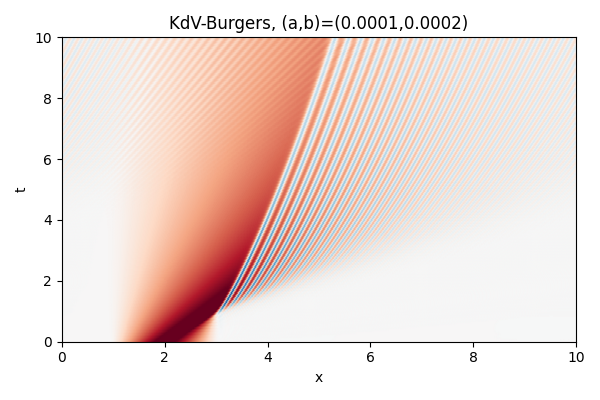

In [9]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_list), np.array(u_list), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-0.8, 0.8))
plt.xlim(0, Lx)
plt.ylim(0, stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'KdV-Burgers, (a,b)=({a},{b})')
plt.tight_layout()
plt.savefig('kdv_burgers.pdf')
plt.savefig('kdv_burgers.png', dpi=200)